In [11]:
import argparse
import os

import yaml
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

import datasets
import models
import utils

from torchvision import transforms
from mmcv.runner import load_checkpoint

import os 
from glob import glob
from PIL import Image
import numpy as np
import cv2
from easydict import EasyDict as edict

from postprocessing.postprocessing_tool import *


# Segmentation by SAM-adapter

- For given image paths, read and inference them by SAM-adapter
- Images are resized by 1024x1024
- Outputs are segmentation maps with sigmoid activation
- Input: images, model (SAM-adapter)
- Output: Segmentation masks

In [12]:
def inference(images, model, data_norm=None, device="cuda"):
    model.eval()
    model = model.to(device)
    if data_norm is None:
        data_norm = {
            'inp': {'sub': [0], 'div': [1]},
            'gt': {'sub': [0], 'div': [1]}
        }
        
    preprocess_SAM = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    # inference mask from images
    preds = []
    for img in images:
        width, height = img.size
        
        with torch.no_grad():
            inp = preprocess_SAM(img).to(device)
        
            pred = torch.sigmoid(model.infer(inp.unsqueeze(0)))
            pred = torch.nn.functional.interpolate(pred, size=(height, width), mode='bilinear', align_corners=False)
            
        preds.append((pred[0].permute(1, 2, 0).squeeze(-1).cpu().numpy() * 255).astype(np.uint8))
    return preds
        

# Postprocessing to Obtain Masks and Holes

## Overview  
This process consists of **six steps** to generate masks and holes from a given segmentation map.

### **Pipeline Steps**  
1. **Binarization** – Convert the input into a binary mask.  
2. **Skeletonization** – Extract "lines" from the binarized mask.  
3. **Skeleton Postprocessing** – Remove short or abnormal lines.  
4. **Clearance Mask Generation** – Identify areas where holes cannot exist.  
5. **Hole Generation** – Distribute holes uniformly using a grid.  

---

## **Inputs & Outputs**  

### **Inputs**  
- `ann_img` – Segmentation map.  
- `raw_img` – Original RGB image.  

### **Outputs**  
- **Clearance Mask** – Defines areas where holes cannot exist.  
- **Holes** – Estimated positions of holes.  

---

## **Parameters**  

| Parameter                 | Description |
|---------------------------|-------------|
| `hole_min_distance`       | Minimum distance between holes |
| `hole_gridsearch_distance` | Distance between hole candidates |
| `fragile_clearance`       | Distance from edges to refine clearance areas |

---

## **Saving Outputs**  
If `output_dir` and `basename` are provided, intermediate outputs and hole information will be saved in:  



In [ ]:
def Postprocess(ann_img, raw_img, parameters=edict({}), output_dir=None, basename=None):
    """
    Run the full processing pipeline on two input ndarrays.

    Parameters:
      ann_img    - grayscale annotation image (ndarray)
      raw_img    - raw color image (BGR, ndarray)
      parameters - parameters for assigning the positions of holes
      output_dir - directory in which to save the results (if available)
      basename   - base filename used for naming output files (if available)
    """
    # Parameters that needs to be adjusted
    hole_min_distance = parameters.hole_min_distance
    hole_gridsearch_distance = parameters.hole_gridsearch_distance
    fragile_clearance = parameters.fragile_clearance
    
    # Hardcoded parameters
    method = 'medial'
    closing_level = 1
    opening_level = 1
    median_blur_ksize = 3
    morph_ksize = 3
    min_length_threshold = 20  # Remove segments shorter than this.
    branch_proximity = 5  # For branch detection.
    thresh_roi = 0  # All pixels are included.
    noise_std = 3
    safety_factor = 3

    # ---- Step 1: Raw Annotation ----
    raw_annotation = step1_raw_annotation(ann_img)
    
    # ---- Step 2: Binarized Image ----
    binarized = step2_binarize(ann_img, closing_level, opening_level, median_blur_ksize, morph_ksize)
    
    # ---- Step 3: Skeletonization ----
    skeleton = step3_skeletonize(binarized, method=method)
    
    # ---- Step 4: Skeleton Postprocess ----
    skeleton_post = step4_skeleton_postprocess(skeleton, ann_img, min_length_threshold, branch_proximity)
    
    # ---- Step 5: Clearance Mask ----
    clearance_mask = step5_clearance_mask(skeleton_post, fragile_clearance)
    
    # ---- Step 6: Generate Holes ----
    holes = step6_generate_holes(ann_img, skeleton_post, hole_min_distance, hole_gridsearch_distance,
                                 fragile_clearance, noise_std, safety_factor, thresh_roi)
    
    # 취약영역 고려하지 않은 천공 생성

    holes_2=step6_generate_holes_2(ann_img, hole_min_distance, hole_gridsearch_distance,noise_std )

    # 노이즈 않은 천공 생성

    holes_3=step6_generate_holes_3(ann_img, skeleton_post, hole_min_distance, hole_gridsearch_distance,
                                 fragile_clearance,noise_std, safety_factor,thresh_roi)
    
    if output_dir is not None:
        assert basename is not None, "basename should be given when we save intermediate results"
        
        # Create output subdirectory if it does not exist.
        out_subdir = os.path.join(output_dir, basename)
        if not os.path.exists(out_subdir):
            os.makedirs(out_subdir)
        
        # Save outputs from each step
        visualize_step1(raw_annotation, os.path.join(out_subdir, f"{basename}_Step1_RawAnnotation.png"))
        visualize_step2(binarized, os.path.join(out_subdir, f"{basename}_Step2_Binarized.png"))
        visualize_step3(skeleton, os.path.join(out_subdir, f"{basename}_Step3_Skeleton.png"))
        visualize_step4(skeleton_post, os.path.join(out_subdir, f"{basename}_Step4_SkeletonPostprocess.png"))
        clearance_mask_blur = visualize_step5(clearance_mask, os.path.join(out_subdir, f"{basename}_Step5_ClearanceMask.png"))
        holes_vis = visualize_step6(skeleton_post, holes, hole_min_distance, os.path.join(out_subdir, f"{basename}_Step6_Holes.png"))
            
        # Save CSV of holes coordinates.
        csv_filename = os.path.join(out_subdir, f"{basename}_Step6_Holes.csv")

        # 취약영역 반영하지 않은 천공 후보군 

        csv_filename_2= os.path.join(out_subdir, f"{basename}_Step6_Holes_2.csv")


        csv_filename_3= os.path.join(out_subdir, f"{basename}_Step6_Holes_3.csv")
        
        save_csv(holes, csv_filename)

        save_csv_2(holes_2, csv_filename_2)

        save_csv_3(holes_3, csv_filename_3)
        
        # ----- Verification: Read CSV and visualize the holes -----
        verification_img = cv2.cvtColor(skeleton_post, cv2.COLOR_GRAY2BGR)
        with open(csv_filename, 'r') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header.
            for row in reader:
                x, y = int(row[0]), int(row[1])
                cv2.circle(verification_img, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
        cv2.imwrite(os.path.join(out_subdir, f"{basename}_verification_holes.png"), verification_img)
        
        #취약영역 고려하지 않은 것 생성

        height, width = skeleton_post.shape  # skeleton_post는 안 쓰지만 크기만 가져옴
        verification_img_2 = np.zeros((height, width, 3), dtype=np.uint8)

        
        with open(csv_filename_2, 'r') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header.
            for row in reader:
                x, y = int(row[0]), int(row[1])
                cv2.circle(verification_img_2, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
        cv2.imwrite(os.path.join(out_subdir, f"{basename}_verification_holes_2.png"), verification_img_2)

        #노이즈즈 않은 것 생성

        verification_img_3 = cv2.cvtColor(skeleton_post, cv2.COLOR_GRAY2BGR)
        with open(csv_filename_3, 'r') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header.
            for row in reader:
                x, y = int(row[0]), int(row[1])
                cv2.circle(verification_img_3 , (x, y), radius=5, color=(0, 0, 255), thickness=-1)
        cv2.imwrite(os.path.join(out_subdir, f"{basename}_verification_holes_3.png"), verification_img_3)


        # ---- MasterVisualization (Final Alpha Blended Result) ----
        master_vis = MasterVisualization(raw_img, verification_img, 0.7, 0.3)
        visualize_MasterVisualization(master_vis, os.path.join(out_subdir, f"{basename}_MasterVisualization.png"))

        # 천공 위치 고려하지 않은 것 생성

        master_vis_2 = MasterVisualization(raw_img, verification_img_2, 0.7, 0.3)
        visualize_MasterVisualization(master_vis_2, os.path.join(out_subdir, f"{basename}_MasterVisualization_2.png"))

        # 경계선만 넣은 것 
        verification_img_4 = cv2.cvtColor(skeleton_post, cv2.COLOR_GRAY2BGR)
        master_vis_3 = MasterVisualization(raw_img, verification_img_4, 0.7, 0.3)
        visualize_MasterVisualization(master_vis_3, os.path.join(out_subdir, f"{basename}_MasterVisualization_3.png"))
        
        # Optional: Concatenation of master visualization and raw image
        raw_img_resized = cv2.resize(raw_img, (128, 128))
        master_vis_resized = cv2.resize(master_vis, (128, 128))
        concat_h = np.hstack((master_vis_resized, raw_img_resized))
        cv2.imwrite(os.path.join(out_subdir, "Concatenated_Result.png"), concat_h)
        

        images_path= r"data\0-0.jpg"
        # 원본 이미지 복사
        result_img = cv2.imread(images_path)

        # 1. 경계선 위치에 흰색 덮어쓰기 (skeleton_post가 255인 픽셀만)
        result_img[skeleton_post == 255] = [0, 255, 255]  

        # 2. 천공 위치 (CSV에 저장된 좌표)에 빨간 점 찍기
        with open(csv_filename, 'r') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header
            for row in reader:
                x, y = int(row[0]), int(row[1])
                cv2.circle(result_img, (x, y), radius=7, color=(0, 0, 255), thickness=-1)  # 빨간색

        # 3. 결과 저장
        cv2.imwrite(os.path.join(out_subdir, f"{basename}_direct_overlay.png"), result_img)



################### 경게선 고려 없이 천공 위치 결정정

         images_path= r"data\0-0.jpg"
        # 원본 이미지 복사
        result_img = cv2.imread(images_path)

        # 1. 경계선 위치에 흰색 덮어쓰기 (skeleton_post가 255인 픽셀만)
        result_img[skeleton_post == 255] = [0, 255, 255]  

        # 2. 천공 위치 (CSV에 저장된 좌표)에 빨간 점 찍기
        with open(csv_filename, 'r') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header
            for row in reader:
                x, y = int(row[0]), int(row[1])
                cv2.circle(result_img, (x, y), radius=7, color=(0, 0, 255), thickness=-1)  # 빨간색

        # 3. 결과 저장
        cv2.imwrite(os.path.join(out_subdir, f"{basename}_direct_overlay.png"), result_img)

    return clearance_mask, holes

# Main

In [14]:

# Load and inference SAM with a given image paths ('images_path')
args = edict({
    'config': 'configs/custom-b.yaml', # config from SAM-adapter
    'model': "checkpoint\save\_custom-b\model_epoch_best.pth", # checkpoint path from SAM-adapter
    'images_path': "data/", # path to test images
    'save_path': "inference_250514", # path to save
})

with open(args.config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = models.make(config['model']).cuda()
sam_checkpoint = torch.load(args.model, map_location='cuda:0')
model.load_state_dict(sam_checkpoint, strict=True)

fns = sorted(glob(os.path.join(args.images_path, "*")))

# Read images
images = []
for fn in fns:
    images.append(Image.open(fn))

preds = inference(images, model)


# Postprocess the segmentation mask to obtain holes
args_postprocess = edict({})
args_postprocess.hole_min_distance = 75 # Minimum distance between holes
args_postprocess.hole_gridsearch_distance = 15  # Grid search spacing for assigning the positions of holes.
args_postprocess.fragile_clearance = 20 # Minimum distance from detected edges (to obtain area that holes can exist)

clearance_mask_total, holes_total = [], []
for pred, image, fn in zip(preds, images, fns):
    clearance_mask, holes = Postprocess(pred, np.array(image.convert("RGB")), args_postprocess, output_dir=args.save_path, basename=os.path.basename(fn))
    clearance_mask_total.append(clearance_mask)
    holes_total.append(holes)

# You can use or edit the clearance mask and holes
# ===============================================================
for pred, image, fn, clearance_mask, holes in zip (preds, images, fns, clearance_mask_total, holes_total):
    # save or edit them
    pass
# ===============================================================

C:\Users\USER\AppData\Local\Temp\ipykernel_26100\709625929.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sam_checkpoint = torch.load(args.model, map_location='cuda:0'

0-0.jpg_MasterVisualization.png


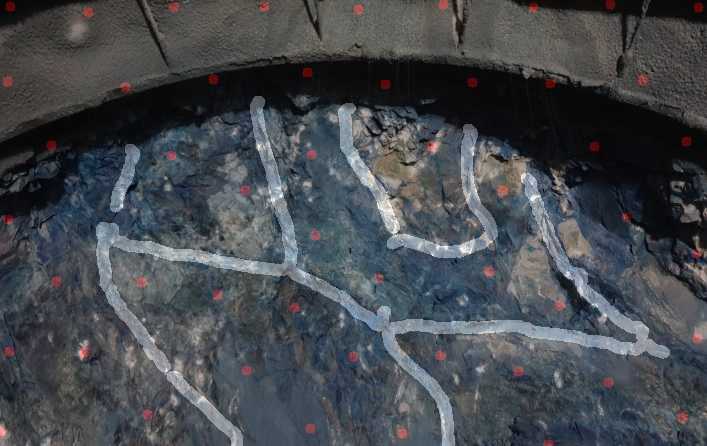

0-0.jpg_MasterVisualization_2.png


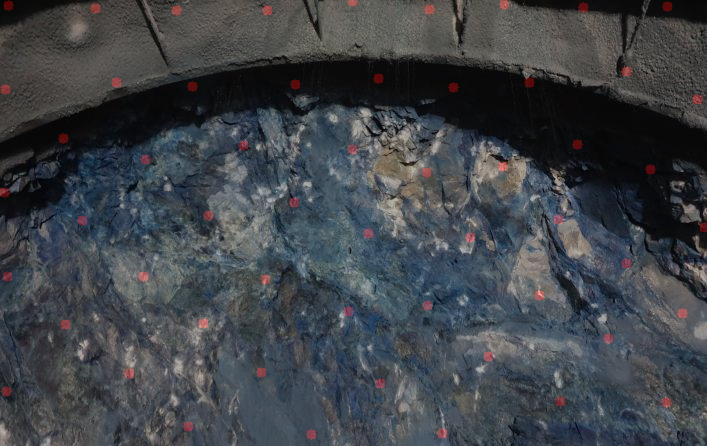

0-0.jpg_MasterVisualization_3.png


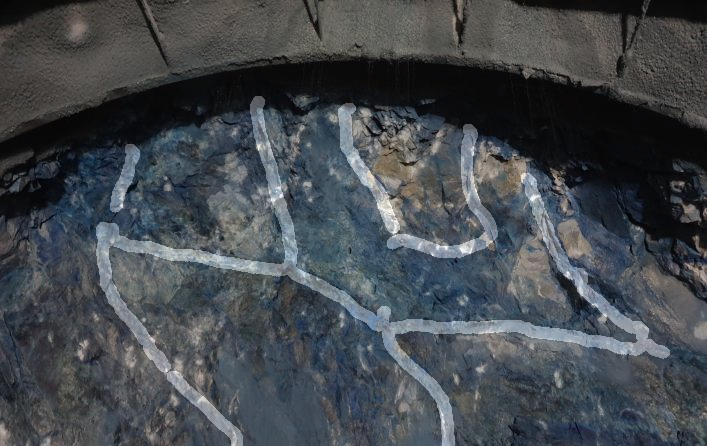

0-0.jpg_Step1_RawAnnotation.png


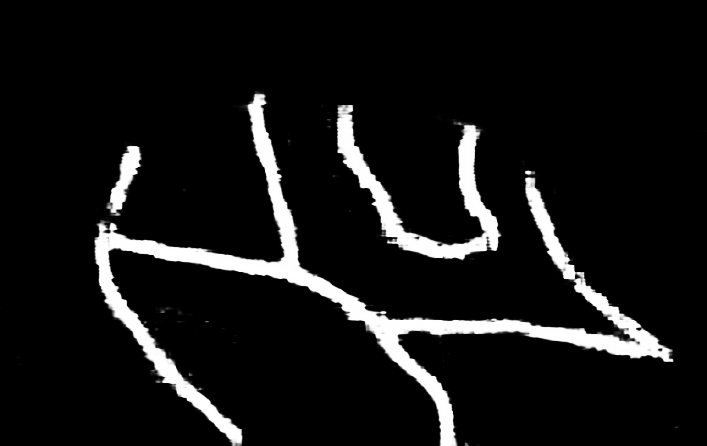

0-0.jpg_Step2_Binarized.png


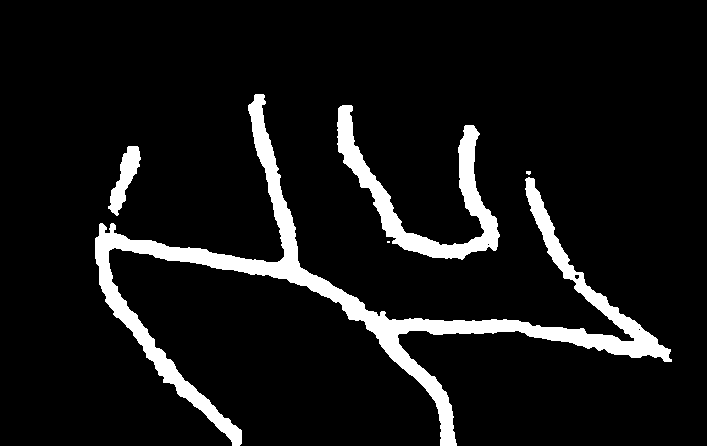

0-0.jpg_Step3_Skeleton.png


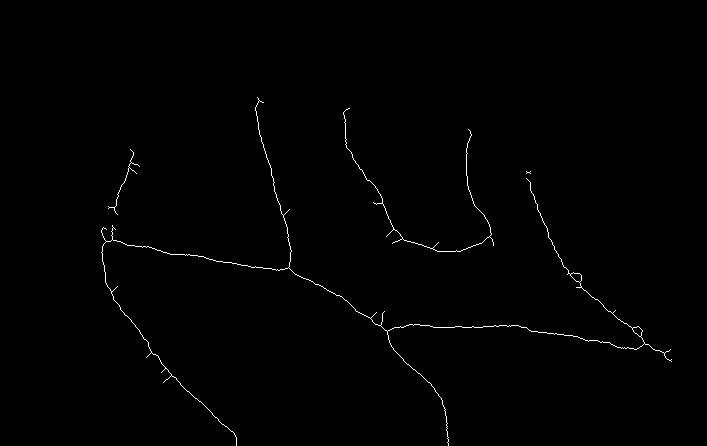

0-0.jpg_Step4_SkeletonPostprocess.png


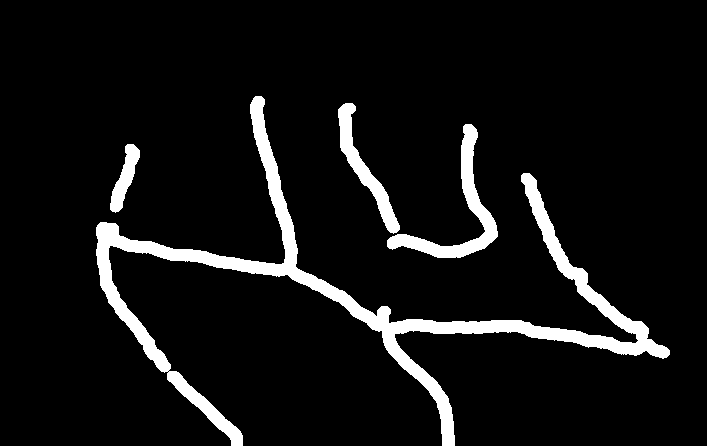

0-0.jpg_Step5_ClearanceMask.png


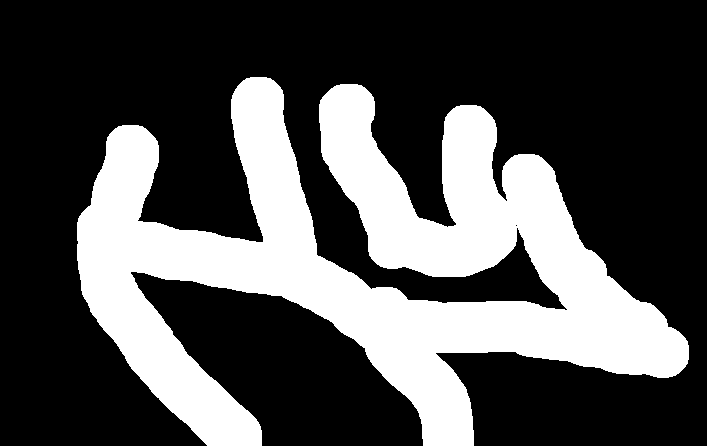

0-0.jpg_Step6_Holes.png


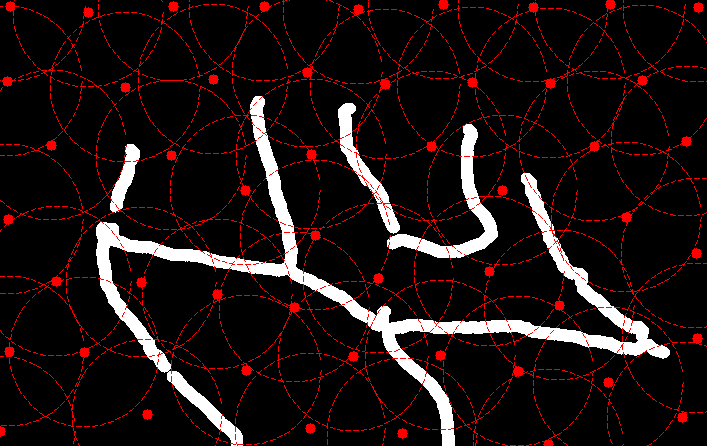

0-0.jpg_direct_overlay.png


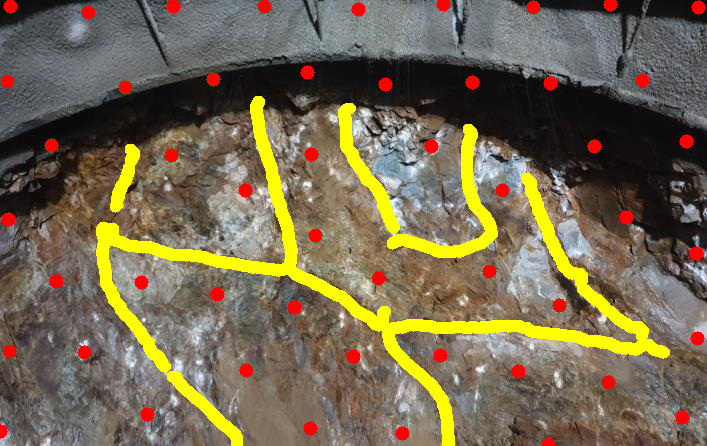

0-0.jpg_verification_holes.png


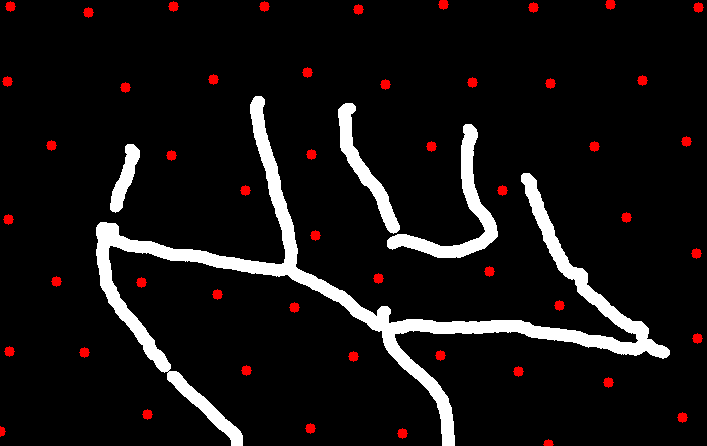

0-0.jpg_verification_holes_2.png


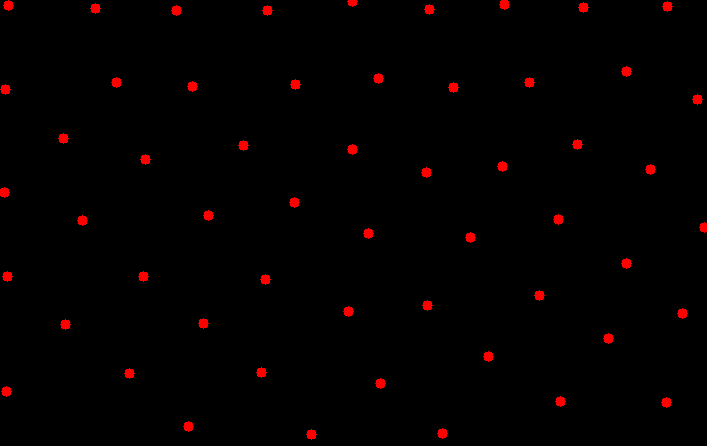

0-0.jpg_verification_holes_3.png


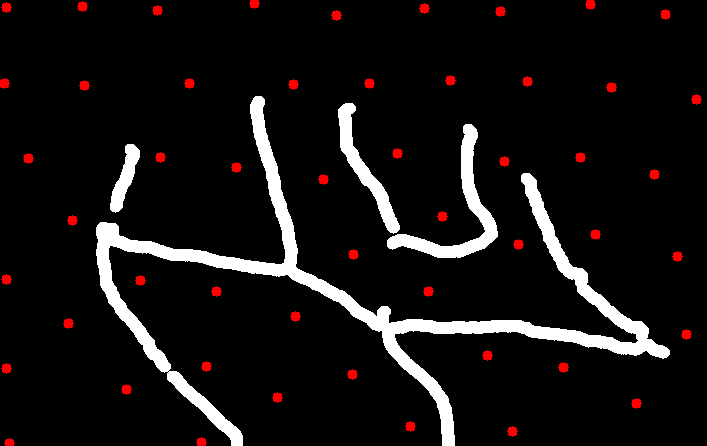

Concatenated_Result.png


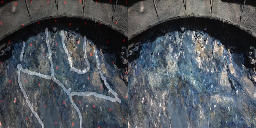

In [15]:

from IPython.display import display

# Load a first result from save_path and visualize them
pred, image, fn = preds[0], images[0], fns[0]
results = sorted(glob(os.path.join(args.save_path, os.path.basename(fns[0]), '*.png')))

for result in results:
    img = Image.open(result)

    print(os.path.basename(result))
    display(img)

